In [1]:
%matplotlib widget
#import matplotlib.pyplot as plt
from helper import *
from Simulation.WaitTime import WaitTime
from Simulation.MoveJoint import MoveJoint
from Simulation.MoveLinear import MoveLinear
from Simulation.MoveTrajectory import MoveTrajectory
from Simulation.Simulation import Simulation
from Simulation.ForwardKinematics import ForwardKinematics
from neura_dual_quaternions import DualQuaternion, Quaternion

from DualQuaternionQuinticBlends.LineGenerator import LineGenerator
from DualQuaternionQuinticBlends.ArcGenerator import ArcGenerator
from DualQuaternionQuinticBlends.DQQBTrajectoryGenerator import DQQBTrajectoryGenerator
np.set_printoptions(precision=3, suppress=True, linewidth=1200, threshold=np.inf)

In [2]:
robot_type = "weld"

fk = ForwardKinematics(robot_type)

q2 = np.array([0, deg2rad(-60), 0, deg2rad(-60), 0, deg2rad(-60), 0])
q3 = -q2

q4 = np.array([deg2rad(20), deg2rad(0), deg2rad(-20), deg2rad(90), deg2rad(0), deg2rad(-90), deg2rad(0)])
q5 = np.array([deg2rad(-3), deg2rad(20), deg2rad(3), deg2rad(90), deg2rad(3), deg2rad(20), deg2rad(-3)])

quat0 = Quaternion.fromAxisAngle(np.pi*0.5, np.array([0,1,0]))
quat1 = Quaternion.fromAxisAngle(np.pi*0.5, np.array([0,0,1]))

x1 = DualQuaternion.fromQuatPos(quat0, np.array([0.350, 0, 1.138]))
x11 = DualQuaternion.fromQuatPos(quat0, np.array([0.815, 0, 1.138]))
x2 = DualQuaternion.fromQuatPos(quat1*quat0, np.array([0.815, 0, 1.138]))     
x3 = DualQuaternion.fromQuatPos(quat0, np.array([0.917, -0.2, 1.138]))   

# define orientation quaternions for test trajectory
quat1 = Quaternion(1,0,0,0)
quat2 = Quaternion(0,1,0,0)

# define dual quaternions for linear interpolation
dq1 = DualQuaternion.fromQuatPos(quat1, np.array([1, 0, 0.5]))
dq2 = DualQuaternion.fromQuatPos(quat1, np.array([0.6, 0, 0.5 ]))
dq3 = DualQuaternion.fromQuatPos(quat2, np.array([0.6, 0, 0.5 ]))
dq4 = DualQuaternion.fromQuatPos(quat2, np.array([0.6, 0.3, 0.5 ]))

# assign dual quaternions to lists
line_DQ_list = [dq1, dq2, dq3, dq4]

# initialize line and arc generators
line_generator = LineGenerator()

# define the acceleration and jerk limits
a_cart_max = 2
j_cart_max = 30
a_ang_max = 3
j_ang_max = 30

# define desired cartesian velocites and maximum angular velocity
des_cart_vel_line = 0.1
max_ang_vel = 1

# generate segments
segments = line_generator.generateSegments(line_DQ_list, des_cart_vel_line, max_ang_vel)

# generate trajectory object with the segments defined above
trajectory1 = DQQBTrajectoryGenerator()
trajectory1.generateDynamicTrajectory(segments, a_cart_max, j_cart_max, a_ang_max, j_ang_max)

#task_list = np.array([MoveJoint(q5, 3), WaitTime(5)])
task_list = np.array([MoveJoint(q4, 2), MoveLinear(fk.getFK(q4), x1, 2), MoveLinear(x1, x11, 2), MoveLinear(x11, x2, 2), WaitTime(.1), MoveLinear(x2, x3, 2), MoveLinear(x3, dq1, 2)])
#task_list = np.array([MoveJoint(q4, 2), MoveLinear(fk.getFK(q4), x1, 2), MoveLinear(x1, x11, 2), WaitTime(1)])
#task_list = np.array([WaitTime(2), MoveJoint(q2, 3),  MoveJoint(q3, 3), WaitTime(2),  MoveJoint(q4, 3),  MoveJoint(q5, 3)])
sim = Simulation(task_list, robot_type)

iteration:  1
acceleration limit violated!
acceleration limit violated!
acceleration limit violated!
acceleration limit violated!
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
[0.1414213562373135, 0.5, 0.5, 0.14142135623731455]


In [3]:
sim.start()

[0.002, 0.002, 0.0060160000000000005, 0.010064, 0.014144, 0.018256, 0.0224, 0.026576000000000002, 0.030784, 0.035024, 0.039296000000000005]
[0, 2, 4, 6, 8, 8.1, 10.1, 12.1]


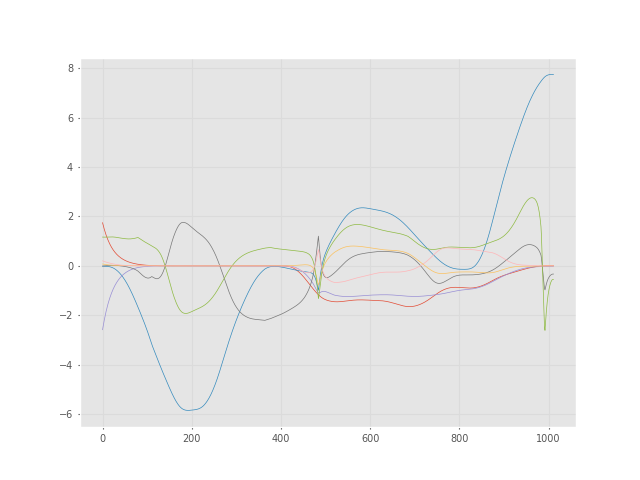

In [4]:
%matplotlib widget
plt.plot(sim.q_dot_list)
plt.show()